In [2]:
pip install graphframes-py==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [graphframes-py]
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from graphframes import GraphFrame
import os
#spark=SparkSession.builder.appName("graph").master("local[*]").getOrCreate()

spark = SparkSession.builder.appName("graphs")\
        .config('spark.jars.packages', 'io.graphframes:graphframes-spark4_2.13:0.10.0')\
        .master("local[*]")\
        .getOrCreate()

vertics = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 37),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 38),
  ("g", "Gabby", 60)
], ["id", "name", "age"])


# Edges DataFrame
edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend"),
  ("g", "e", "follow")
], ["src", "dst", "relationship"])

# Create a GraphFrame
g = GraphFrame(vertics, edges)
g.vertices.show()
g.edges.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/15 19:18:23 WARN Utils: Your hostname, Thuy-Trangs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.146.116.1 instead (on interface en0)
26/01/15 19:18:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/thuytrangskalska/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/thuytrangskalska/.ivy2.5.2/cache
The jars for the packages stored in: /Users/thuytrangskalska/.ivy2.5.2/jars
io.graphframes#graphframes-spark4_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-64c14434-75fc-44eb-a1ef-ac43ea4ca962;1.0
	confs: [default]
	found io.graphframes#graphframes-spark4_2.13;0.10.0 in central
	found io.graphframes#graphframes-graphx-spark4_2.13;0.10.0 in central
:: resolution report :: resol

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 37|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 38|
|  g|  Gabby| 60|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
|  g|  e|      follow|
+---+---+------------+



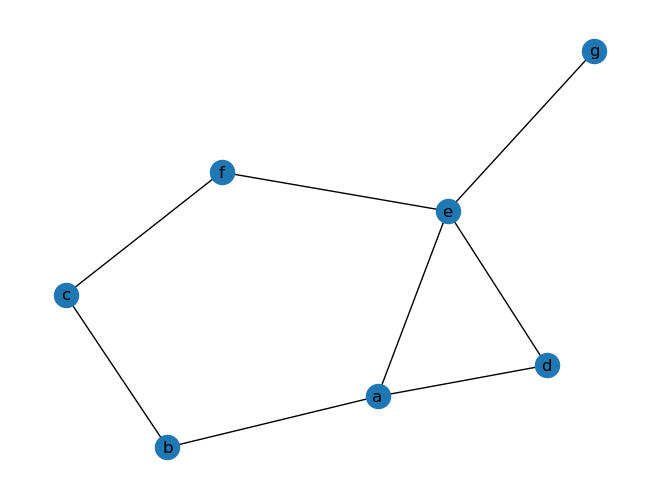

In [5]:
import networkx as nx

graph_pandas = g.edges.toPandas()
nxg = nx.from_pandas_edgelist(graph_pandas, 'src', 'dst')
nx.draw(nxg, with_labels=True)

In [6]:
from graphframes.classic.graphframe import StorageLevel
results = g.triangleCount(storage_level=StorageLevel.MEMORY_ONLY)
results.show()

26/01/15 19:19:24 WARN AggregateMessages: Returned DataFrame is persistent and materialized!
26/01/15 19:19:31 WARN TriangleCount$: Returned DataFrame is persistent and materialized!


+---+-------+---+----+------------+----+------------+-----+
| id|   name|age| src|src_triplets| dst|dst_triplets|count|
+---+-------+---+----+------------+----+------------+-----+
|  g|  Gabby| 60|NULL|        NULL|NULL|        NULL|    0|
|  f|  Fanny| 38|NULL|        NULL|NULL|        NULL|    0|
|  e| Esther| 32|NULL|        NULL|   e|           2|    1|
|  d|  David| 29|   d|           1|   d|           1|    1|
|  c|Charlie| 37|NULL|        NULL|NULL|        NULL|    0|
|  b|    Bob| 36|NULL|        NULL|NULL|        NULL|    0|
|  a|  Alice| 34|   a|           2|NULL|        NULL|    1|
+---+-------+---+----+------------+----+------------+-----+



In [7]:
results = g.shortestPaths(landmarks=['a', 'c'])
results.show()

26/01/15 19:20:00 WARN ShortestPaths: Returned DataFrame is persistent and materialized!


+---+-------+---+----------------+
| id|   name|age|       distances|
+---+-------+---+----------------+
|  g|  Gabby| 60|{c -> 3, a -> 3}|
|  b|    Bob| 36|        {c -> 1}|
|  e| Esther| 32|{c -> 2, a -> 2}|
|  a|  Alice| 34|{c -> 2, a -> 0}|
|  f|  Fanny| 38|        {c -> 1}|
|  d|  David| 29|{c -> 3, a -> 1}|
|  c|Charlie| 37|        {c -> 0}|
+---+-------+---+----------------+

